# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Tue Jun  3 16:23:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8             17W /   80W |     691MiB /   6144MiB |     51%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [3]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [4]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model_bce",
    checkpoints_dir="../checkpoints/standard_model_bce",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=150,  # Prilagodite broj epoha prema potrebi
    decay_epoch=50,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=10,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [5]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 150
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [6]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [7]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    discriminator_update_freq=1,
    loss_type='BCE'
)

Epoha 1/150: 100%|██████████| 115/115 [00:36<00:00,  3.12it/s, D_A=0.6660, D_B=0.6700, G=3.2792]


Epoha 1/150 - Train gubici: G: 6.6386, D_A: 0.6383, D_B: 0.5666 | Val gubici: G: 2.5054, Cycle: 1.4460
Novi najbolji validacijski cycle gubitak: 1.4460, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.5054, spremam modele...


Epoha 2/150: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, D_A=0.6561, D_B=0.5340, G=3.0361]


Epoha 2/150 - Train gubici: G: 3.0775, D_A: 0.6581, D_B: 0.6326 | Val gubici: G: 2.7693, Cycle: 1.1057
Novi najbolji validacijski cycle gubitak: 1.1057, spremam modele...


Epoha 3/150: 100%|██████████| 115/115 [00:33<00:00,  3.43it/s, D_A=0.6168, D_B=0.5600, G=3.1394]


Epoha 3/150 - Train gubici: G: 2.8803, D_A: 0.6669, D_B: 0.6202 | Val gubici: G: 2.7670, Cycle: 1.2410


Epoha 4/150: 100%|██████████| 115/115 [00:33<00:00,  3.42it/s, D_A=0.6974, D_B=0.5351, G=2.0888]


Epoha 4/150 - Train gubici: G: 2.8549, D_A: 0.6617, D_B: 0.5497 | Val gubici: G: 3.8553, Cycle: 1.0317
Novi najbolji validacijski cycle gubitak: 1.0317, spremam modele...


Epoha 5/150: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, D_A=0.6806, D_B=0.7173, G=2.5490]


Epoha 5/150 - Train gubici: G: 3.1053, D_A: 0.6498, D_B: 0.4844 | Val gubici: G: 3.4432, Cycle: 0.9761
Novi najbolji validacijski cycle gubitak: 0.9761, spremam modele...


Epoha 6/150: 100%|██████████| 115/115 [00:31<00:00,  3.61it/s, D_A=0.6140, D_B=1.4159, G=6.9549]


Epoha 6/150 - Train gubici: G: 3.1899, D_A: 0.6605, D_B: 0.4357 | Val gubici: G: 2.5928, Cycle: 0.9536
Novi najbolji validacijski cycle gubitak: 0.9536, spremam modele...


Epoha 7/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6496, D_B=0.2335, G=3.3723]


Epoha 7/150 - Train gubici: G: 2.9850, D_A: 0.6360, D_B: 0.4295 | Val gubici: G: 2.2069, Cycle: 0.8964
Novi najbolji validacijski cycle gubitak: 0.8964, spremam modele...
Novi najbolji validacijski GAN gubitak: 2.2069, spremam modele...


Epoha 8/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6155, D_B=0.6919, G=3.8634]


Epoha 8/150 - Train gubici: G: 2.9926, D_A: 0.6318, D_B: 0.4231 | Val gubici: G: 2.6303, Cycle: 0.8896
Novi najbolji validacijski cycle gubitak: 0.8896, spremam modele...


Epoha 9/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6170, D_B=0.4910, G=2.3543]


Epoha 9/150 - Train gubici: G: 3.1635, D_A: 0.6271, D_B: 0.3813 | Val gubici: G: 3.6803, Cycle: 0.8425
Novi najbolji validacijski cycle gubitak: 0.8425, spremam modele...


Epoha 10/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.5994, D_B=0.5635, G=2.4401]


Epoha 10/150 - Train gubici: G: 3.1062, D_A: 0.6250, D_B: 0.3921 | Val gubici: G: 4.2082, Cycle: 0.8231
Novi najbolji validacijski cycle gubitak: 0.8231, spremam modele...


Epoha 11/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.5188, D_B=0.2418, G=2.5004]


Epoha 11/150 - Train gubici: G: 2.9574, D_A: 0.6295, D_B: 0.4134 | Val gubici: G: 2.5080, Cycle: 0.8198
Novi najbolji validacijski cycle gubitak: 0.8198, spremam modele...


Epoha 12/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6590, D_B=0.4291, G=2.3673]


Epoha 12/150 - Train gubici: G: 3.0218, D_A: 0.5897, D_B: 0.3940 | Val gubici: G: 2.8040, Cycle: 0.8106
Novi najbolji validacijski cycle gubitak: 0.8106, spremam modele...


Epoha 13/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3637, D_B=0.4434, G=3.4019]


Epoha 13/150 - Train gubici: G: 3.2337, D_A: 0.5393, D_B: 0.3718 | Val gubici: G: 3.4402, Cycle: 0.8468


Epoha 14/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2371, D_B=0.5436, G=3.2522]


Epoha 14/150 - Train gubici: G: 3.0930, D_A: 0.5294, D_B: 0.3963 | Val gubici: G: 3.3459, Cycle: 0.9544


Epoha 15/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2973, D_B=0.2418, G=3.6690]


Epoha 15/150 - Train gubici: G: 3.2397, D_A: 0.4656, D_B: 0.3936 | Val gubici: G: 2.3549, Cycle: 0.8657


Epoha 16/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6331, D_B=0.2336, G=3.2916]


Epoha 16/150 - Train gubici: G: 3.2283, D_A: 0.5398, D_B: 0.4293 | Val gubici: G: 5.0287, Cycle: 0.9501


Epoha 17/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2789, D_B=0.4618, G=2.7224]


Epoha 17/150 - Train gubici: G: 3.1663, D_A: 0.5323, D_B: 0.3935 | Val gubici: G: 4.2433, Cycle: 0.9619


Epoha 18/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2115, D_B=0.3572, G=5.0429]


Epoha 18/150 - Train gubici: G: 3.3075, D_A: 0.4926, D_B: 0.3995 | Val gubici: G: 2.6461, Cycle: 0.9849


Epoha 19/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6415, D_B=0.7951, G=3.1879]


Epoha 19/150 - Train gubici: G: 3.3592, D_A: 0.4902, D_B: 0.3808 | Val gubici: G: 5.0190, Cycle: 0.9235


Epoha 20/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.6210, D_B=0.4795, G=2.5487]


Epoha 20/150 - Train gubici: G: 3.1954, D_A: 0.4624, D_B: 0.4186 | Val gubici: G: 4.3148, Cycle: 1.0188


Epoha 21/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3159, D_B=0.4199, G=4.1696]


Epoha 21/150 - Train gubici: G: 3.1831, D_A: 0.4908, D_B: 0.4202 | Val gubici: G: 2.6343, Cycle: 1.0353


Epoha 22/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2600, D_B=0.7594, G=2.4708]


Epoha 22/150 - Train gubici: G: 3.3264, D_A: 0.4748, D_B: 0.4530 | Val gubici: G: 4.0793, Cycle: 0.9229


Epoha 23/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.7353, D_B=0.1234, G=2.7795]


Epoha 23/150 - Train gubici: G: 3.0953, D_A: 0.5196, D_B: 0.4154 | Val gubici: G: 2.0758, Cycle: 0.9080
Novi najbolji validacijski GAN gubitak: 2.0758, spremam modele...


Epoha 24/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3932, D_B=0.7889, G=2.6011]


Epoha 24/150 - Train gubici: G: 3.2133, D_A: 0.4467, D_B: 0.4040 | Val gubici: G: 2.9008, Cycle: 0.9520


Epoha 25/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.7623, D_B=0.4587, G=2.9339]


Epoha 25/150 - Train gubici: G: 3.1720, D_A: 0.4442, D_B: 0.4260 | Val gubici: G: 3.2827, Cycle: 1.0007


Epoha 26/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.4433, D_B=0.6958, G=2.8962]


Epoha 26/150 - Train gubici: G: 3.2591, D_A: 0.4684, D_B: 0.4103 | Val gubici: G: 2.4776, Cycle: 0.9948


Epoha 27/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2366, D_B=0.3960, G=2.9437]


Epoha 27/150 - Train gubici: G: 3.2977, D_A: 0.4323, D_B: 0.3921 | Val gubici: G: 3.1038, Cycle: 0.9512


Epoha 28/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2076, D_B=0.1396, G=1.8066]


Epoha 28/150 - Train gubici: G: 3.2430, D_A: 0.4636, D_B: 0.3974 | Val gubici: G: 1.7255, Cycle: 1.0124
Novi najbolji validacijski GAN gubitak: 1.7255, spremam modele...


Epoha 29/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3730, D_B=0.2667, G=3.5310]


Epoha 29/150 - Train gubici: G: 3.3293, D_A: 0.4393, D_B: 0.3755 | Val gubici: G: 1.9501, Cycle: 0.9780


Epoha 30/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.5005, D_B=0.5397, G=2.7103]


Epoha 30/150 - Train gubici: G: 3.2135, D_A: 0.4167, D_B: 0.3852 | Val gubici: G: 4.3841, Cycle: 1.0391


Epoha 31/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2924, D_B=0.4088, G=2.2684]


Epoha 31/150 - Train gubici: G: 3.5218, D_A: 0.4031, D_B: 0.4309 | Val gubici: G: 1.9265, Cycle: 1.1264


Epoha 32/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2845, D_B=0.0891, G=3.7014]


Epoha 32/150 - Train gubici: G: 3.4514, D_A: 0.4120, D_B: 0.4029 | Val gubici: G: 1.8216, Cycle: 0.9865


Epoha 33/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.7937, D_B=0.3630, G=4.4443]


Epoha 33/150 - Train gubici: G: 3.3526, D_A: 0.4533, D_B: 0.3755 | Val gubici: G: 2.6905, Cycle: 0.9814


Epoha 34/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.6995, D_B=0.0534, G=3.1044]


Epoha 34/150 - Train gubici: G: 3.4967, D_A: 0.3955, D_B: 0.3726 | Val gubici: G: 2.8727, Cycle: 0.9956


Epoha 35/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.4895, D_B=0.6194, G=5.7495]


Epoha 35/150 - Train gubici: G: 3.3514, D_A: 0.3958, D_B: 0.4043 | Val gubici: G: 4.0485, Cycle: 1.0570


Epoha 36/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3586, D_B=0.2689, G=3.4492]


Epoha 36/150 - Train gubici: G: 3.6044, D_A: 0.3802, D_B: 0.3780 | Val gubici: G: 4.9274, Cycle: 1.0222


Epoha 37/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2024, D_B=0.4418, G=3.6316]


Epoha 37/150 - Train gubici: G: 3.3902, D_A: 0.4327, D_B: 0.3815 | Val gubici: G: 2.1934, Cycle: 1.1050


Epoha 38/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.4395, D_B=0.1774, G=3.4540]


Epoha 38/150 - Train gubici: G: 3.4277, D_A: 0.3874, D_B: 0.3851 | Val gubici: G: 2.9010, Cycle: 0.9980


Epoha 39/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.6422, D_B=0.6764, G=1.9538]


Epoha 39/150 - Train gubici: G: 3.4904, D_A: 0.3757, D_B: 0.3972 | Val gubici: G: 6.4024, Cycle: 0.9948


Epoha 40/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2432, D_B=0.0597, G=2.7021]


Epoha 40/150 - Train gubici: G: 3.5532, D_A: 0.4086, D_B: 0.3758 | Val gubici: G: 1.7098, Cycle: 1.1418
Novi najbolji validacijski GAN gubitak: 1.7098, spremam modele...


Epoha 41/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.4765, D_B=0.5619, G=2.5961]


Epoha 41/150 - Train gubici: G: 3.4777, D_A: 0.4011, D_B: 0.3764 | Val gubici: G: 6.1016, Cycle: 1.0054


Epoha 42/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2520, D_B=0.4969, G=2.9559]


Epoha 42/150 - Train gubici: G: 3.5112, D_A: 0.4021, D_B: 0.3726 | Val gubici: G: 3.2913, Cycle: 0.9529


Epoha 43/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.7149, D_B=0.0856, G=5.7061]


Epoha 43/150 - Train gubici: G: 3.5089, D_A: 0.3792, D_B: 0.3543 | Val gubici: G: 1.9234, Cycle: 0.9791


Epoha 44/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3094, D_B=0.2731, G=2.7208]


Epoha 44/150 - Train gubici: G: 3.8144, D_A: 0.3654, D_B: 0.3410 | Val gubici: G: 2.6766, Cycle: 1.1062


Epoha 45/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2239, D_B=0.2928, G=2.9766]


Epoha 45/150 - Train gubici: G: 3.5559, D_A: 0.3928, D_B: 0.3584 | Val gubici: G: 1.5888, Cycle: 1.0206
Novi najbolji validacijski GAN gubitak: 1.5888, spremam modele...


Epoha 46/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.5333, D_B=0.6134, G=3.1925] 


Epoha 46/150 - Train gubici: G: 3.8657, D_A: 0.3799, D_B: 0.8405 | Val gubici: G: 2.7196, Cycle: 1.0091


Epoha 47/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.0601, D_B=0.6481, G=2.3401]


Epoha 47/150 - Train gubici: G: 3.0908, D_A: 0.4405, D_B: 0.6789 | Val gubici: G: 1.9993, Cycle: 0.9052


Epoha 48/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.3267, D_B=0.6578, G=2.3699]


Epoha 48/150 - Train gubici: G: 2.8094, D_A: 0.3954, D_B: 0.6816 | Val gubici: G: 1.8749, Cycle: 0.8546


Epoha 49/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.7310, D_B=0.7024, G=3.1059]


Epoha 49/150 - Train gubici: G: 2.9108, D_A: 0.3680, D_B: 0.6820 | Val gubici: G: 2.2668, Cycle: 0.9481


Epoha 50/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.8164, D_B=0.6282, G=2.3155]


Epoha 50/150 - Train gubici: G: 2.8735, D_A: 0.3432, D_B: 0.6775 | Val gubici: G: 4.0914, Cycle: 0.9478


Epoha 51/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2093, D_B=0.6324, G=2.7900]


Epoha 51/150 - Train gubici: G: 2.8062, D_A: 0.3876, D_B: 0.6776 | Val gubici: G: 2.8112, Cycle: 0.7561
Novi najbolji validacijski cycle gubitak: 0.7561, spremam modele...


Epoha 52/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.2282, D_B=0.6359, G=4.0606]


Epoha 52/150 - Train gubici: G: 2.9946, D_A: 0.3567, D_B: 0.6741 | Val gubici: G: 2.2930, Cycle: 0.9494


Epoha 53/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.4270, D_B=0.7448, G=2.7017]


Epoha 53/150 - Train gubici: G: 2.9110, D_A: 0.3536, D_B: 0.6603 | Val gubici: G: 4.0551, Cycle: 0.8469


Epoha 54/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1387, D_B=0.5934, G=3.1573]


Epoha 54/150 - Train gubici: G: 2.9063, D_A: 0.3378, D_B: 0.6600 | Val gubici: G: 2.1852, Cycle: 0.8928


Epoha 55/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.4857, D_B=0.4661, G=4.3112]


Epoha 55/150 - Train gubici: G: 2.8910, D_A: 0.3583, D_B: 0.6492 | Val gubici: G: 2.2118, Cycle: 0.9240


Epoha 56/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2862, D_B=0.5186, G=3.0605]


Epoha 56/150 - Train gubici: G: 3.0380, D_A: 0.3314, D_B: 0.6348 | Val gubici: G: 3.7843, Cycle: 0.9052


Epoha 57/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.9733, D_B=0.8137, G=1.9127]


Epoha 57/150 - Train gubici: G: 3.0451, D_A: 0.3788, D_B: 0.6181 | Val gubici: G: 4.9479, Cycle: 0.9343


Epoha 58/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.4888, D_B=0.3301, G=2.4038]


Epoha 58/150 - Train gubici: G: 3.1161, D_A: 0.3527, D_B: 0.5863 | Val gubici: G: 3.1975, Cycle: 0.9720


Epoha 59/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1263, D_B=0.7444, G=4.2063]


Epoha 59/150 - Train gubici: G: 3.2510, D_A: 0.3533, D_B: 0.5537 | Val gubici: G: 2.3227, Cycle: 1.0687


Epoha 60/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3011, D_B=0.7436, G=3.1753]


Epoha 60/150 - Train gubici: G: 3.3844, D_A: 0.3350, D_B: 0.4762 | Val gubici: G: 3.9874, Cycle: 1.0297


Epoha 61/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.5834, D_B=0.1780, G=2.7240]


Epoha 61/150 - Train gubici: G: 3.5017, D_A: 0.3829, D_B: 0.4200 | Val gubici: G: 4.3532, Cycle: 0.9097


Epoha 62/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0192, D_B=0.5182, G=2.7357]


Epoha 62/150 - Train gubici: G: 3.5106, D_A: 0.3446, D_B: 0.4376 | Val gubici: G: 3.0872, Cycle: 0.9237


Epoha 63/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2773, D_B=0.6948, G=4.0200]


Epoha 63/150 - Train gubici: G: 3.4450, D_A: 0.3499, D_B: 0.3902 | Val gubici: G: 3.6939, Cycle: 0.9680


Epoha 64/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1750, D_B=0.3866, G=3.7206]


Epoha 64/150 - Train gubici: G: 3.7431, D_A: 0.3124, D_B: 0.3702 | Val gubici: G: 4.8481, Cycle: 1.0015


Epoha 65/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1979, D_B=0.4660, G=3.2619]


Epoha 65/150 - Train gubici: G: 3.6167, D_A: 0.3356, D_B: 0.3990 | Val gubici: G: 4.0224, Cycle: 0.9512


Epoha 66/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1076, D_B=0.2583, G=3.1309]


Epoha 66/150 - Train gubici: G: 3.4466, D_A: 0.3510, D_B: 0.3797 | Val gubici: G: 1.9414, Cycle: 0.9341


Epoha 67/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3857, D_B=0.4575, G=3.9252]


Epoha 67/150 - Train gubici: G: 3.4187, D_A: 0.3578, D_B: 0.4020 | Val gubici: G: 4.0894, Cycle: 1.0106


Epoha 68/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.7734, D_B=0.2678, G=3.5878]


Epoha 68/150 - Train gubici: G: 3.2862, D_A: 0.3155, D_B: 0.3693 | Val gubici: G: 4.0975, Cycle: 0.9322


Epoha 69/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2848, D_B=0.2175, G=4.2702]


Epoha 69/150 - Train gubici: G: 3.5416, D_A: 0.3217, D_B: 0.3737 | Val gubici: G: 2.4275, Cycle: 0.9776


Epoha 70/150: 100%|██████████| 115/115 [00:31<00:00,  3.67it/s, D_A=0.1455, D_B=0.3344, G=3.0690]


Epoha 70/150 - Train gubici: G: 3.5031, D_A: 0.3350, D_B: 0.3648 | Val gubici: G: 3.7005, Cycle: 0.9690


Epoha 71/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.4669, D_B=0.3020, G=4.2337]


Epoha 71/150 - Train gubici: G: 3.5393, D_A: 0.3098, D_B: 0.3563 | Val gubici: G: 3.4825, Cycle: 0.9097


Epoha 72/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3912, D_B=0.4639, G=2.9744]


Epoha 72/150 - Train gubici: G: 3.6498, D_A: 0.3495, D_B: 0.3646 | Val gubici: G: 2.4330, Cycle: 0.9323


Epoha 73/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2381, D_B=0.1657, G=6.1935]


Epoha 73/150 - Train gubici: G: 3.9481, D_A: 0.3047, D_B: 0.3291 | Val gubici: G: 4.5673, Cycle: 1.0409


Epoha 74/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.2351, D_B=0.3657, G=2.7725]


Epoha 74/150 - Train gubici: G: 3.9128, D_A: 0.2937, D_B: 0.3083 | Val gubici: G: 2.3269, Cycle: 0.9820


Epoha 75/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0414, D_B=0.1078, G=4.8631]


Epoha 75/150 - Train gubici: G: 3.9168, D_A: 0.2775, D_B: 0.3223 | Val gubici: G: 2.9081, Cycle: 0.9898


Epoha 76/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.5688, D_B=0.3492, G=2.6463]


Epoha 76/150 - Train gubici: G: 3.9852, D_A: 0.2765, D_B: 0.3297 | Val gubici: G: 5.3082, Cycle: 0.8850


Epoha 77/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3448, D_B=0.3487, G=4.9020]


Epoha 77/150 - Train gubici: G: 3.7947, D_A: 0.3909, D_B: 0.3210 | Val gubici: G: 4.8613, Cycle: 1.0891


Epoha 78/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1392, D_B=0.3542, G=3.8703]


Epoha 78/150 - Train gubici: G: 3.8141, D_A: 0.2833, D_B: 0.3143 | Val gubici: G: 5.7819, Cycle: 0.9437


Epoha 79/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.0223, D_B=0.3222, G=3.8162]


Epoha 79/150 - Train gubici: G: 3.7943, D_A: 0.3067, D_B: 0.3159 | Val gubici: G: 2.8743, Cycle: 0.9274


Epoha 80/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1321, D_B=0.1675, G=3.4194]


Epoha 80/150 - Train gubici: G: 3.8448, D_A: 0.2803, D_B: 0.3037 | Val gubici: G: 2.3750, Cycle: 0.9383


Epoha 81/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.1678, D_B=0.4906, G=3.9286]


Epoha 81/150 - Train gubici: G: 3.8279, D_A: 0.3267, D_B: 0.2890 | Val gubici: G: 5.2076, Cycle: 0.9238


Epoha 82/150: 100%|██████████| 115/115 [00:31<00:00,  3.66it/s, D_A=0.3013, D_B=0.2447, G=3.4140]


Epoha 82/150 - Train gubici: G: 4.0153, D_A: 0.3009, D_B: 0.2888 | Val gubici: G: 3.9353, Cycle: 0.8985


Epoha 83/150: 100%|██████████| 115/115 [00:31<00:00,  3.62it/s, D_A=0.4311, D_B=0.1751, G=3.1252]


Epoha 83/150 - Train gubici: G: 3.9316, D_A: 0.2918, D_B: 0.2896 | Val gubici: G: 4.2025, Cycle: 0.9247


Epoha 84/150: 100%|██████████| 115/115 [00:34<00:00,  3.37it/s, D_A=0.0783, D_B=0.3609, G=4.1510]


Epoha 84/150 - Train gubici: G: 4.1067, D_A: 0.2339, D_B: 0.2907 | Val gubici: G: 3.9542, Cycle: 0.9258


Epoha 85/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.1720, D_B=0.1671, G=3.7743]


Epoha 85/150 - Train gubici: G: 4.1590, D_A: 0.2654, D_B: 0.2788 | Val gubici: G: 5.5141, Cycle: 0.9821


Epoha 86/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.5103, D_B=0.2337, G=3.8622]


Epoha 86/150 - Train gubici: G: 4.0561, D_A: 0.3163, D_B: 0.2778 | Val gubici: G: 6.4842, Cycle: 0.9198


Epoha 87/150: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s, D_A=0.1854, D_B=0.3488, G=3.6428]


Epoha 87/150 - Train gubici: G: 4.0606, D_A: 0.2824, D_B: 0.2750 | Val gubici: G: 3.5926, Cycle: 0.9372


Epoha 88/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.3926, D_B=0.3148, G=3.3300]


Epoha 88/150 - Train gubici: G: 4.0547, D_A: 0.3113, D_B: 0.2676 | Val gubici: G: 4.0813, Cycle: 0.9724


Epoha 89/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0349, D_B=0.2690, G=3.3109]


Epoha 89/150 - Train gubici: G: 4.1413, D_A: 0.2819, D_B: 0.2513 | Val gubici: G: 2.8794, Cycle: 0.9687


Epoha 90/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0958, D_B=0.1308, G=3.7411]


Epoha 90/150 - Train gubici: G: 4.1719, D_A: 0.2315, D_B: 0.2426 | Val gubici: G: 1.9911, Cycle: 0.9761


Epoha 91/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.1765, D_B=0.2622, G=5.1586]


Epoha 91/150 - Train gubici: G: 4.1726, D_A: 0.2736, D_B: 0.2771 | Val gubici: G: 4.2973, Cycle: 0.9905


Epoha 92/150: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s, D_A=0.2889, D_B=0.2915, G=3.2794]


Epoha 92/150 - Train gubici: G: 4.0870, D_A: 0.2757, D_B: 0.2509 | Val gubici: G: 3.4669, Cycle: 0.9125


Epoha 93/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.1424, D_B=0.4848, G=3.5293]


Epoha 93/150 - Train gubici: G: 4.2647, D_A: 0.2699, D_B: 0.2421 | Val gubici: G: 6.5141, Cycle: 0.9946


Epoha 94/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.1253, D_B=0.1539, G=5.0643]


Epoha 94/150 - Train gubici: G: 4.3258, D_A: 0.2705, D_B: 0.2409 | Val gubici: G: 5.7172, Cycle: 0.9216


Epoha 95/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.2873, D_B=0.3450, G=5.2661]


Epoha 95/150 - Train gubici: G: 4.3000, D_A: 0.2750, D_B: 0.2479 | Val gubici: G: 4.9323, Cycle: 0.9980


Epoha 96/150: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s, D_A=0.0535, D_B=0.1832, G=4.7127]


Epoha 96/150 - Train gubici: G: 4.5945, D_A: 0.1997, D_B: 0.2393 | Val gubici: G: 4.5850, Cycle: 1.0308


Epoha 97/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0506, D_B=0.0958, G=4.2107]


Epoha 97/150 - Train gubici: G: 4.5817, D_A: 0.1857, D_B: 0.2346 | Val gubici: G: 3.8452, Cycle: 0.9834


Epoha 98/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.1101, D_B=0.0608, G=4.2114]


Epoha 98/150 - Train gubici: G: 4.3043, D_A: 0.2680, D_B: 0.2350 | Val gubici: G: 3.9638, Cycle: 0.9338


Epoha 99/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.3610, D_B=0.1675, G=3.4257]


Epoha 99/150 - Train gubici: G: 4.4454, D_A: 0.2650, D_B: 0.2250 | Val gubici: G: 2.9828, Cycle: 0.9158


Epoha 100/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.2525, D_B=0.3420, G=4.8443]


Epoha 100/150 - Train gubici: G: 4.5880, D_A: 0.2321, D_B: 0.2163 | Val gubici: G: 3.6033, Cycle: 0.9816


Epoha 101/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0815, D_B=0.0961, G=3.3490]


Epoha 101/150 - Train gubici: G: 4.5928, D_A: 0.2346, D_B: 0.2168 | Val gubici: G: 2.9088, Cycle: 1.0129


Epoha 102/150: 100%|██████████| 115/115 [00:33<00:00,  3.47it/s, D_A=0.2462, D_B=0.1662, G=4.5734]


Epoha 102/150 - Train gubici: G: 4.6032, D_A: 0.2394, D_B: 0.2121 | Val gubici: G: 5.1229, Cycle: 0.9498


Epoha 103/150: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s, D_A=0.4099, D_B=0.2793, G=2.8448]


Epoha 103/150 - Train gubici: G: 4.6218, D_A: 0.2173, D_B: 0.2180 | Val gubici: G: 4.3263, Cycle: 0.9725


Epoha 104/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.5142, D_B=0.0850, G=2.6509]


Epoha 104/150 - Train gubici: G: 4.6921, D_A: 0.2021, D_B: 0.2098 | Val gubici: G: 4.1151, Cycle: 0.9666


Epoha 105/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.0166, D_B=0.2483, G=3.7072]


Epoha 105/150 - Train gubici: G: 4.6972, D_A: 0.2076, D_B: 0.2075 | Val gubici: G: 3.5633, Cycle: 0.9697


Epoha 106/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.3605, D_B=0.0875, G=3.7201]


Epoha 106/150 - Train gubici: G: 4.7179, D_A: 0.2300, D_B: 0.1884 | Val gubici: G: 4.4307, Cycle: 0.9300


Epoha 107/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.0105, D_B=0.1884, G=5.3000]


Epoha 107/150 - Train gubici: G: 4.8252, D_A: 0.1850, D_B: 0.1926 | Val gubici: G: 3.6453, Cycle: 0.9839


Epoha 108/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.4897, D_B=0.4359, G=3.5508]


Epoha 108/150 - Train gubici: G: 4.8562, D_A: 0.2160, D_B: 0.1835 | Val gubici: G: 4.6245, Cycle: 0.9443


Epoha 109/150: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s, D_A=0.0760, D_B=0.4276, G=4.0902]


Epoha 109/150 - Train gubici: G: 4.6849, D_A: 0.2549, D_B: 0.1845 | Val gubici: G: 6.0097, Cycle: 0.9772


Epoha 110/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.0882, D_B=0.0524, G=6.4977]


Epoha 110/150 - Train gubici: G: 4.8472, D_A: 0.2204, D_B: 0.1886 | Val gubici: G: 4.4148, Cycle: 0.9466


Epoha 111/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0038, D_B=0.0711, G=6.3723]


Epoha 111/150 - Train gubici: G: 4.8073, D_A: 0.2335, D_B: 0.1763 | Val gubici: G: 5.8947, Cycle: 0.9607


Epoha 112/150: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s, D_A=0.2820, D_B=0.1423, G=4.2037]


Epoha 112/150 - Train gubici: G: 4.9651, D_A: 0.2417, D_B: 0.1763 | Val gubici: G: 4.2584, Cycle: 0.9531


Epoha 113/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0115, D_B=0.2052, G=4.5121]


Epoha 113/150 - Train gubici: G: 4.8370, D_A: 0.1804, D_B: 0.1867 | Val gubici: G: 2.8519, Cycle: 0.9728


Epoha 114/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.2999, D_B=0.4005, G=5.0771]


Epoha 114/150 - Train gubici: G: 4.9960, D_A: 0.1602, D_B: 0.1748 | Val gubici: G: 5.2485, Cycle: 0.9223


Epoha 115/150: 100%|██████████| 115/115 [00:33<00:00,  3.45it/s, D_A=0.0121, D_B=0.2265, G=4.5368]


Epoha 115/150 - Train gubici: G: 5.1610, D_A: 0.1638, D_B: 0.1712 | Val gubici: G: 5.1760, Cycle: 0.9781


Epoha 116/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0189, D_B=0.2776, G=4.5537]


Epoha 116/150 - Train gubici: G: 5.2620, D_A: 0.1325, D_B: 0.1729 | Val gubici: G: 5.1819, Cycle: 0.9346


Epoha 117/150: 100%|██████████| 115/115 [00:33<00:00,  3.46it/s, D_A=0.0862, D_B=0.1809, G=6.4140]


Epoha 117/150 - Train gubici: G: 5.3147, D_A: 0.1434, D_B: 0.1693 | Val gubici: G: 3.9316, Cycle: 0.9548


Epoha 118/150: 100%|██████████| 115/115 [00:33<00:00,  3.44it/s, D_A=0.0891, D_B=0.0890, G=4.3839]


Epoha 118/150 - Train gubici: G: 5.2163, D_A: 0.1574, D_B: 0.1657 | Val gubici: G: 5.3990, Cycle: 0.9457


Epoha 119/150: 100%|██████████| 115/115 [00:33<00:00,  3.39it/s, D_A=0.2212, D_B=0.1226, G=4.5616]


Epoha 119/150 - Train gubici: G: 5.2524, D_A: 0.1579, D_B: 0.1586 | Val gubici: G: 4.4493, Cycle: 0.9467


Epoha 120/150: 100%|██████████| 115/115 [00:33<00:00,  3.40it/s, D_A=0.1185, D_B=0.3115, G=5.0749]


Epoha 120/150 - Train gubici: G: 5.3551, D_A: 0.1340, D_B: 0.1614 | Val gubici: G: 5.6047, Cycle: 0.9387


Epoha 121/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.0853, D_B=0.1602, G=6.8287]


Epoha 121/150 - Train gubici: G: 5.5425, D_A: 0.1163, D_B: 0.1544 | Val gubici: G: 5.8662, Cycle: 0.9512


Epoha 122/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0796, D_B=0.1236, G=7.5314]


Epoha 122/150 - Train gubici: G: 5.4871, D_A: 0.1364, D_B: 0.1551 | Val gubici: G: 5.5789, Cycle: 0.9495


Epoha 123/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0080, D_B=0.1932, G=4.5960]


Epoha 123/150 - Train gubici: G: 5.4732, D_A: 0.1426, D_B: 0.1509 | Val gubici: G: 4.9002, Cycle: 0.9565


Epoha 124/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1279, D_B=0.1026, G=5.6540]


Epoha 124/150 - Train gubici: G: 5.3906, D_A: 0.1594, D_B: 0.1563 | Val gubici: G: 5.4692, Cycle: 0.9460


Epoha 125/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1716, D_B=0.1306, G=5.0968]


Epoha 125/150 - Train gubici: G: 5.7303, D_A: 0.1121, D_B: 0.1473 | Val gubici: G: 4.6093, Cycle: 0.9784


Epoha 126/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2564, D_B=0.2259, G=4.9504]


Epoha 126/150 - Train gubici: G: 5.3590, D_A: 0.1690, D_B: 0.1466 | Val gubici: G: 6.1102, Cycle: 1.0289


Epoha 127/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0249, D_B=0.1885, G=5.4842]


Epoha 127/150 - Train gubici: G: 5.5525, D_A: 0.1515, D_B: 0.1502 | Val gubici: G: 5.6053, Cycle: 0.9304


Epoha 128/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1632, D_B=0.1165, G=5.5500]


Epoha 128/150 - Train gubici: G: 5.5967, D_A: 0.1416, D_B: 0.1439 | Val gubici: G: 7.0267, Cycle: 0.9787


Epoha 129/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2682, D_B=0.1377, G=5.8399]


Epoha 129/150 - Train gubici: G: 5.6628, D_A: 0.1460, D_B: 0.1416 | Val gubici: G: 4.1632, Cycle: 1.0135


Epoha 130/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2733, D_B=0.1863, G=5.2376]


Epoha 130/150 - Train gubici: G: 5.3339, D_A: 0.2026, D_B: 0.1412 | Val gubici: G: 5.1181, Cycle: 0.9204


Epoha 131/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1703, D_B=0.1699, G=4.8733]


Epoha 131/150 - Train gubici: G: 5.5501, D_A: 0.1608, D_B: 0.1361 | Val gubici: G: 6.0278, Cycle: 0.9652


Epoha 132/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1997, D_B=0.1159, G=5.8156]


Epoha 132/150 - Train gubici: G: 5.4656, D_A: 0.1736, D_B: 0.1362 | Val gubici: G: 4.4990, Cycle: 0.9337


Epoha 133/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.3235, D_B=0.1524, G=5.5354]


Epoha 133/150 - Train gubici: G: 5.5769, D_A: 0.1571, D_B: 0.1370 | Val gubici: G: 5.1037, Cycle: 0.9440


Epoha 134/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2322, D_B=0.1119, G=5.1783]


Epoha 134/150 - Train gubici: G: 5.6180, D_A: 0.1486, D_B: 0.1295 | Val gubici: G: 5.1631, Cycle: 0.9479


Epoha 135/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2108, D_B=0.0709, G=6.1910]


Epoha 135/150 - Train gubici: G: 5.6103, D_A: 0.1599, D_B: 0.1274 | Val gubici: G: 5.4670, Cycle: 0.9410


Epoha 136/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0895, D_B=0.0721, G=6.7716]


Epoha 136/150 - Train gubici: G: 5.6237, D_A: 0.1484, D_B: 0.1282 | Val gubici: G: 5.7149, Cycle: 0.9503


Epoha 137/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2624, D_B=0.0978, G=6.8145]


Epoha 137/150 - Train gubici: G: 6.0338, D_A: 0.1090, D_B: 0.1284 | Val gubici: G: 4.7613, Cycle: 0.9500


Epoha 138/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2576, D_B=0.1403, G=6.1865]


Epoha 138/150 - Train gubici: G: 5.8419, D_A: 0.1310, D_B: 0.1264 | Val gubici: G: 5.8053, Cycle: 0.9406


Epoha 139/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1187, D_B=0.1150, G=5.5414]


Epoha 139/150 - Train gubici: G: 5.4934, D_A: 0.1690, D_B: 0.1234 | Val gubici: G: 6.0815, Cycle: 0.9687


Epoha 140/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0655, D_B=0.0926, G=5.9544]


Epoha 140/150 - Train gubici: G: 5.9711, D_A: 0.1204, D_B: 0.1201 | Val gubici: G: 5.2892, Cycle: 0.9592


Epoha 141/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1274, D_B=0.1005, G=5.6054]


Epoha 141/150 - Train gubici: G: 6.0789, D_A: 0.1088, D_B: 0.1190 | Val gubici: G: 5.7540, Cycle: 0.9404


Epoha 142/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1681, D_B=0.1427, G=5.7948]


Epoha 142/150 - Train gubici: G: 5.7685, D_A: 0.1403, D_B: 0.1196 | Val gubici: G: 5.1293, Cycle: 0.9213


Epoha 143/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0603, D_B=0.1073, G=6.0215]


Epoha 143/150 - Train gubici: G: 5.8869, D_A: 0.1288, D_B: 0.1171 | Val gubici: G: 6.4406, Cycle: 0.9206


Epoha 144/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.3413, D_B=0.1052, G=5.8510]


Epoha 144/150 - Train gubici: G: 6.2578, D_A: 0.1031, D_B: 0.1134 | Val gubici: G: 5.0901, Cycle: 0.9474


Epoha 145/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.0530, D_B=0.1654, G=5.8161]


Epoha 145/150 - Train gubici: G: 5.7958, D_A: 0.1425, D_B: 0.1150 | Val gubici: G: 5.9169, Cycle: 0.9229


Epoha 146/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2871, D_B=0.0944, G=6.7695]


Epoha 146/150 - Train gubici: G: 5.8613, D_A: 0.1419, D_B: 0.1131 | Val gubici: G: 5.5217, Cycle: 0.9406


Epoha 147/150: 100%|██████████| 115/115 [00:31<00:00,  3.64it/s, D_A=0.0675, D_B=0.1679, G=6.2443]


Epoha 147/150 - Train gubici: G: 6.1018, D_A: 0.1208, D_B: 0.1115 | Val gubici: G: 6.1511, Cycle: 0.9558


Epoha 148/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.2325, D_B=0.1299, G=5.1455]


Epoha 148/150 - Train gubici: G: 6.2967, D_A: 0.1064, D_B: 0.1100 | Val gubici: G: 6.0394, Cycle: 0.9605


Epoha 149/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.5699, D_B=0.1467, G=5.6404]


Epoha 149/150 - Train gubici: G: 6.1864, D_A: 0.1228, D_B: 0.1111 | Val gubici: G: 5.7706, Cycle: 0.9460


Epoha 150/150: 100%|██████████| 115/115 [00:31<00:00,  3.65it/s, D_A=0.1093, D_B=0.1276, G=6.4703]


Epoha 150/150 - Train gubici: G: 6.2254, D_A: 0.1261, D_B: 0.1099 | Val gubici: G: 6.2834, Cycle: 0.9434

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  7.33it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8020
  MSE: 0.005356
  PSNR: 23.06 dB

T2 -> T1 translacija:
  SSIM: 0.8163
  MSE: 0.005603
  PSNR: 22.75 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8854
  MSE: 0.002988
  PSNR: 25.44 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8594
  MSE: 0.004325
  PSNR: 23.94 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6855
  MSE: 0.008846
  PSNR: 20.88 dB

T2 -> T1 translacija:
  SSIM: 0.7207
  MSE: 0.009241
  PSNR: 20.58 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8218
  MSE: 0.004931
  PSNR: 23.26 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7674
  MSE: 0.007143
  PSNR: 21.76 dB


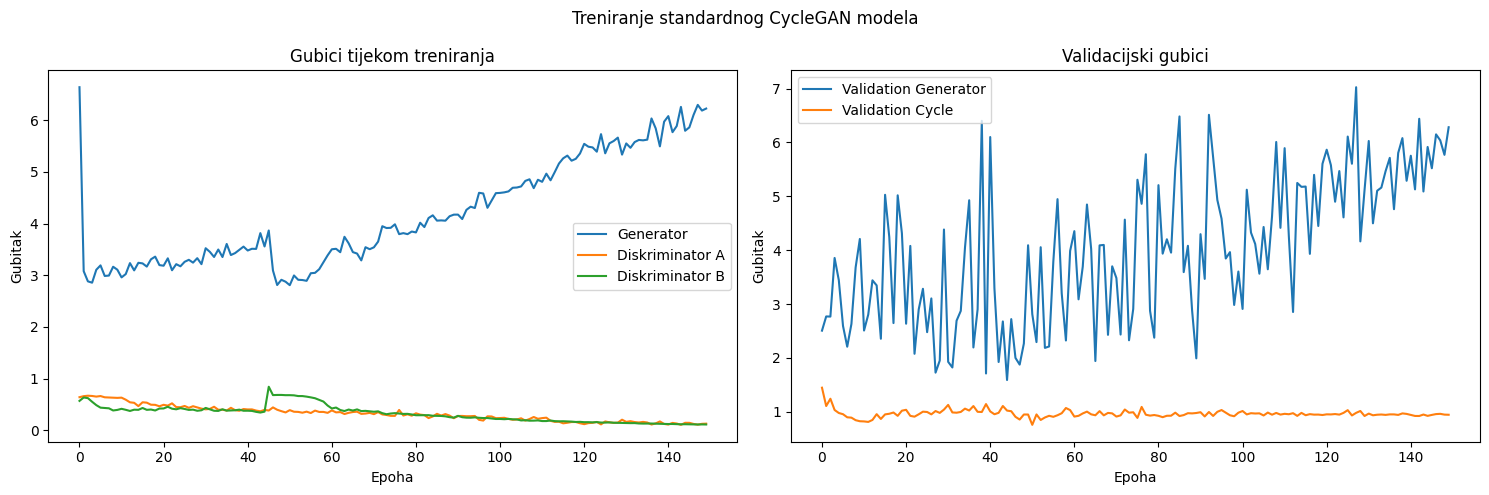

In [8]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [9]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8020
  MSE: 0.005356
  PSNR: 23.06 dB

T2 -> T1 translacija:
  SSIM: 0.8163
  MSE: 0.005603
  PSNR: 22.75 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8854
  MSE: 0.002988
  PSNR: 25.44 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8594
  MSE: 0.004325
  PSNR: 23.94 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.6855
  MSE: 0.008846
  PSNR: 20.88 dB

T2 -> T1 translacija:
  SSIM: 0.7207
  MSE: 0.009241
  PSNR: 20.58 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8218
  MSE: 0.004931
  PSNR: 23.26 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7674
  MSE: 0.007143
  PSNR: 21.76 dB


Vizualizacija rezultata na test setu:


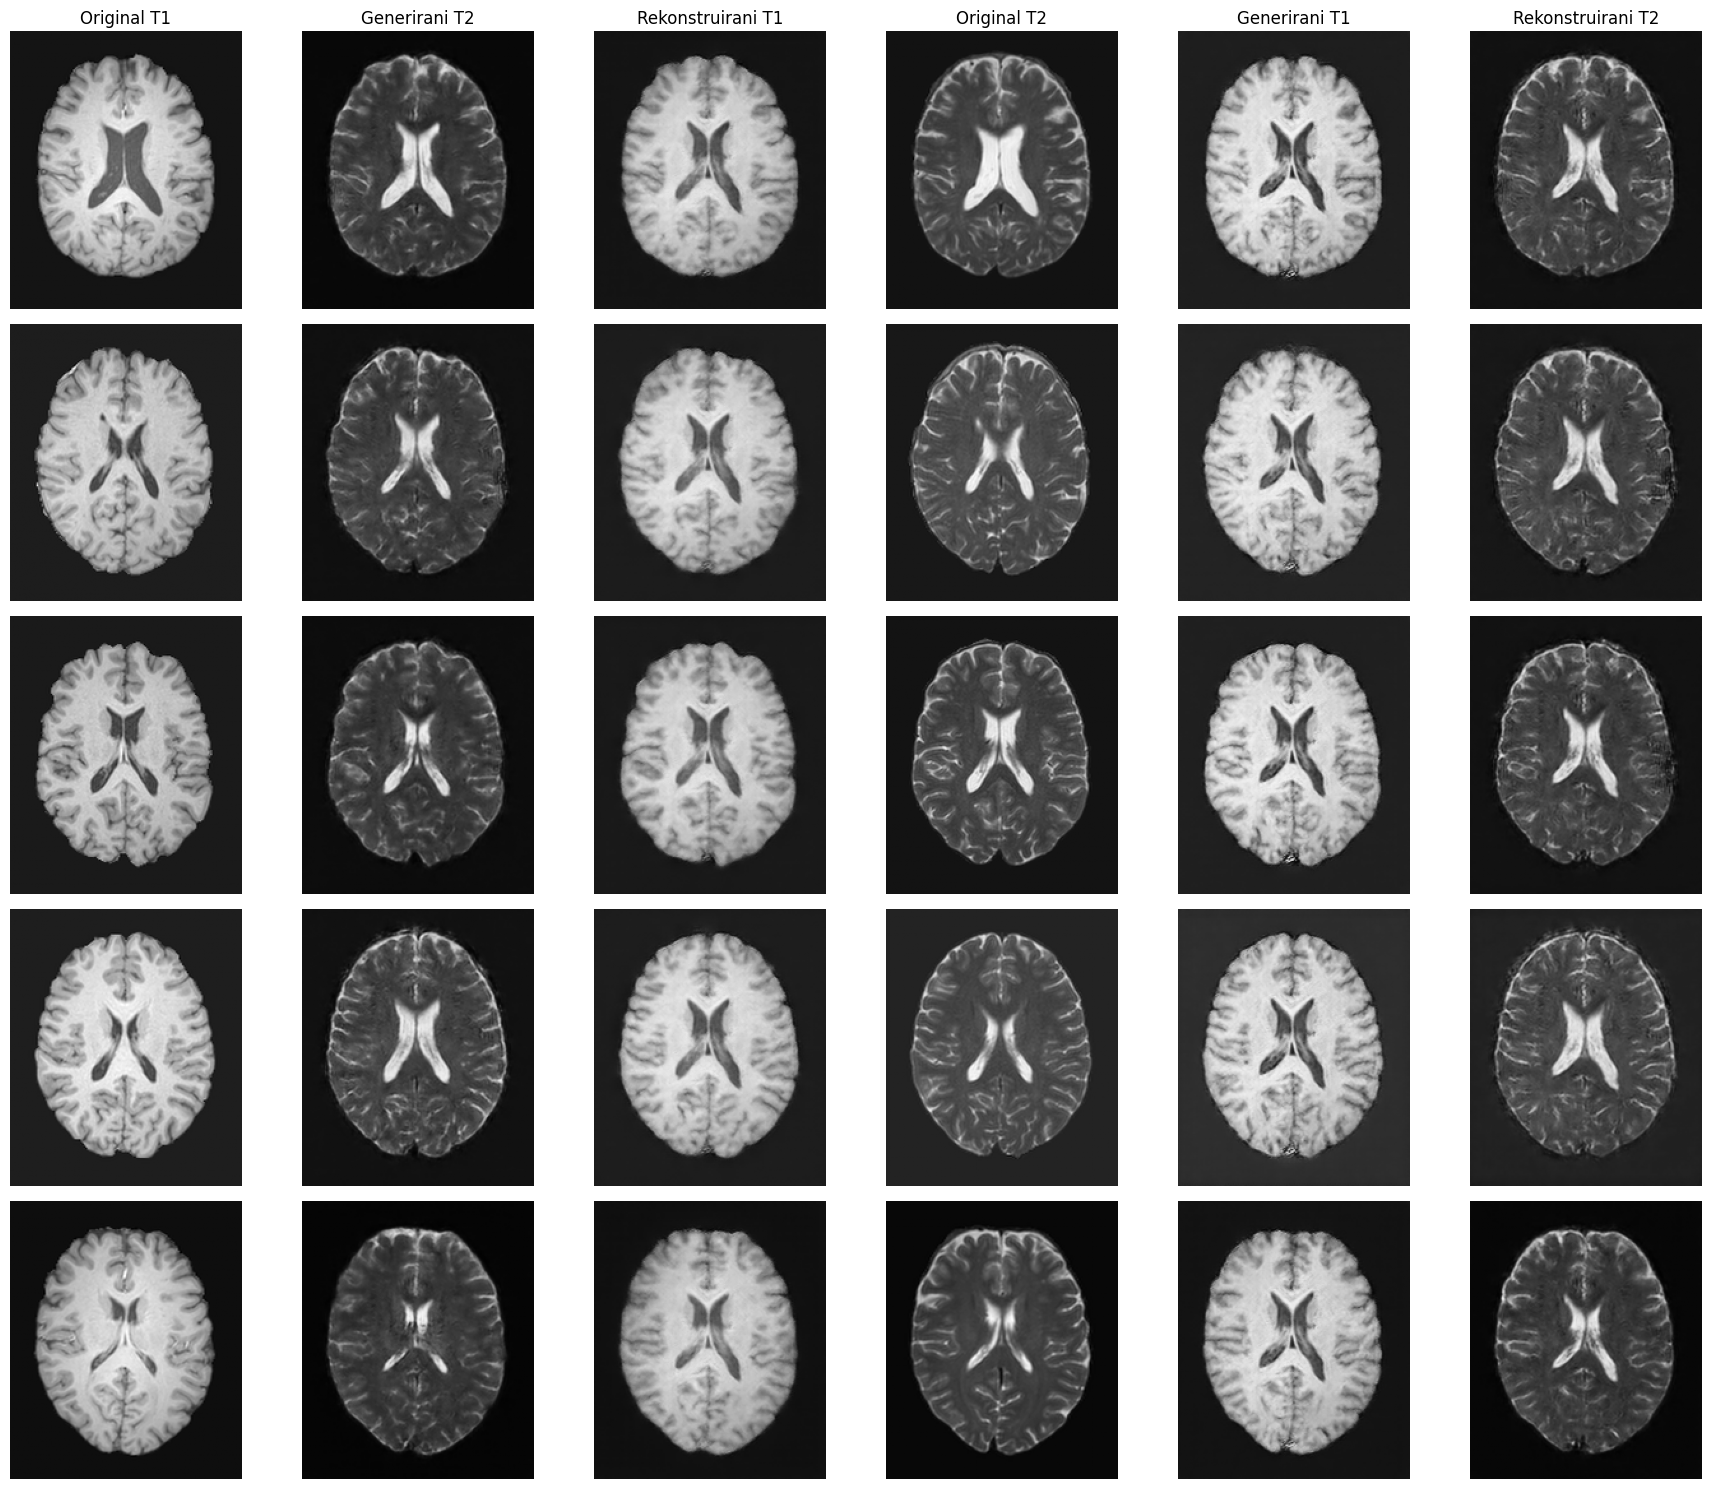

In [10]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=5, config=config)

In [11]:
best_G_AB_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_cycle = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_cycle = f"{config.checkpoints_dir}/G_AB_cycle_best.pth"
best_G_BA_path_cycle = f"{config.checkpoints_dir}/G_BA_cycle_best.pth"
best_G_AB_cycle.load_state_dict(torch.load(best_G_AB_path_cycle, map_location=config.device))
best_G_BA_cycle.load_state_dict(torch.load(best_G_BA_path_cycle, map_location=config.device))

<All keys matched successfully>

In [12]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_cycle, best_G_BA_cycle, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.92it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7435
  MSE: 0.009753
  PSNR: 20.52 dB

T2 -> T1 translacija:
  SSIM: 0.7905
  MSE: 0.006878
  PSNR: 22.09 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9171
  MSE: 0.002295
  PSNR: 26.61 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9057
  MSE: 0.002760
  PSNR: 25.71 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5873
  MSE: 0.016110
  PSNR: 18.34 dB

T2 -> T1 translacija:
  SSIM: 0.6559
  MSE: 0.011361
  PSNR: 19.91 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8620
  MSE: 0.003790
  PSNR: 24.43 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8441
  MSE: 0.004559
  PSNR: 23.53 dB


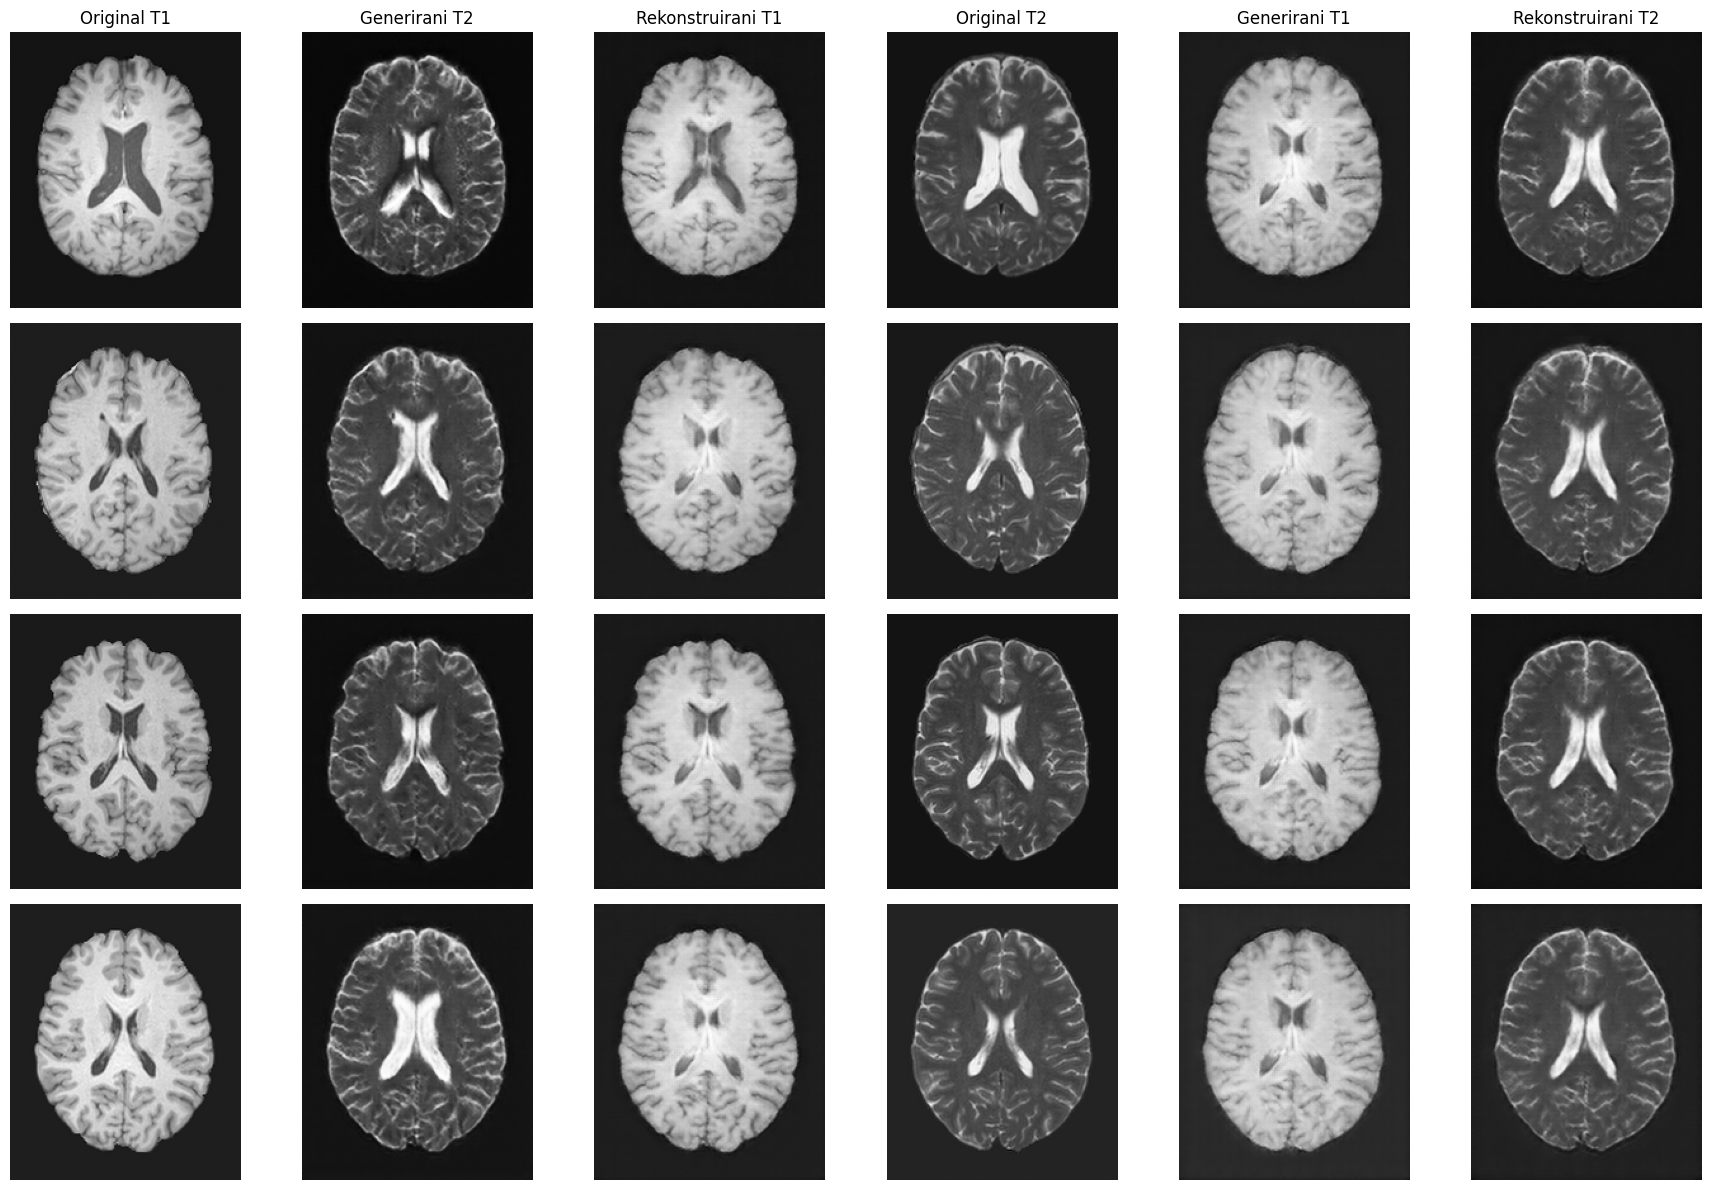

In [13]:
visualize_results(
    best_G_AB_cycle, best_G_BA_cycle, test_dataloader, num_samples=4, config=config
)

In [14]:
best_G_AB_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA_gan = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path_gan = f"{config.checkpoints_dir}/G_AB_gan_best.pth"
best_G_BA_path_gan = f"{config.checkpoints_dir}/G_BA_gan_best.pth"
best_G_AB_gan.load_state_dict(torch.load(best_G_AB_path_gan, map_location=config.device))
best_G_BA_gan.load_state_dict(torch.load(best_G_BA_path_gan, map_location=config.device))

<All keys matched successfully>

In [15]:
print("Testiranje najboljih cyclce modela:")
test_model(best_G_AB_gan, best_G_BA_gan, test_dataloader, config)

Testiranje najboljih cyclce modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.7433
  MSE: 0.009023
  PSNR: 20.75 dB

T2 -> T1 translacija:
  SSIM: 0.7846
  MSE: 0.007637
  PSNR: 21.34 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8888
  MSE: 0.003853
  PSNR: 24.21 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8684
  MSE: 0.003796
  PSNR: 24.42 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.5931
  MSE: 0.014903
  PSNR: 18.57 dB

T2 -> T1 translacija:
  SSIM: 0.6493
  MSE: 0.012614
  PSNR: 19.16 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8158
  MSE: 0.006364
  PSNR: 22.03 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.7886
  MSE: 0.006268
  PSNR: 22.24 dB
